In [1]:
import pandas as pd
import snow.utils as sf

In [3]:
from fbprophet import Prophet

In [4]:
financials = """
SELECT 
	TO_CHAR(TO_DATE(CONVERT_TIMEZONE('UTC', 'Australia/Sydney', CAST(accountcoupon_couponusehistory.time  AS TIMESTAMP_NTZ))), 'YYYY-MM-DD') AS "accountcoupon_couponusehistory.time_date",
	COALESCE(COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE((LEAST(coupon_coupon.amount_limit, coupon_coupon.percent_off/100 * accountcoupon_couponusehistory.bill_amount)) ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (MD5_NUMBER(accountcoupon_couponusehistory.id ) % 1.0e27)::NUMERIC(38,0) ) - SUM(DISTINCT (MD5_NUMBER(accountcoupon_couponusehistory.id ) % 1.0e27)::NUMERIC(38,0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0), 0) AS "accountcoupon_couponusehistory.gross_revenue",
	COALESCE(COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE((GREATEST(accountcoupon_couponusehistory.bill_amount-(case when accountcoupon_couponusehistory.referral_credit_id is not null then (
      case when account_referralcredit.referred_credit  - accountcoupon_couponusehistory.bill_amount <= 0 then account_referralcredit.referred_credit else account_referralcredit.referred_credit - (account_referralcredit.referred_credit - accountcoupon_couponusehistory.bill_amount) end
      )
    else 0 end)-(case
          when accountcoupon_couponusehistory.special_promo_credit_id is not null then (
            case when promo_codes.credit  - accountcoupon_couponusehistory.bill_amount <= 0 then promo_codes.credit else promo_codes.credit - (promo_codes.credit - accountcoupon_couponusehistory.bill_amount) end
            )
          else 0 end)-(case when (coupon_coupon.name LIKE '%Frenzy%') then (LEAST(coupon_coupon.amount_limit, coupon_coupon.percent_off/100 * accountcoupon_couponusehistory.bill_amount)) - (case
      when
        DATEDIFF(DAY,  (TO_CHAR(TO_DATE(CONVERT_TIMEZONE('UTC', 'Australia/Sydney', CAST(accountcoupon_couponusehistory.time  AS TIMESTAMP_NTZ))), 'YYYY-MM-DD')), (TO_CHAR(TO_DATE(CONVERT_TIMEZONE('UTC', 'Australia/Sydney', CAST(branch_branch."ZERO_COMMISSION_UNTIL"  AS TIMESTAMP_NTZ))), 'YYYY-MM-DD'))) > 0 then 0
      when
        coupon_coupon.commission_percent = 0 then 0
        else coupon_coupon.commission_percent/100 * accountcoupon_couponusehistory.bill_amount
    end) else 0 end), 0)) ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (MD5_NUMBER(accountcoupon_couponusehistory.id ) % 1.0e27)::NUMERIC(38,0) ) - SUM(DISTINCT (MD5_NUMBER(accountcoupon_couponusehistory.id ) % 1.0e27)::NUMERIC(38,0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0), 0) AS "accountcoupon_couponusehistory.sum_of_organic_volume",
	COALESCE(COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE(accountcoupon_couponusehistory.bill_amount ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (MD5_NUMBER(accountcoupon_couponusehistory.id ) % 1.0e27)::NUMERIC(38,0) ) - SUM(DISTINCT (MD5_NUMBER(accountcoupon_couponusehistory.id ) % 1.0e27)::NUMERIC(38,0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0), 0) AS "accountcoupon_couponusehistory.total_transaction_volume",
	COALESCE(COALESCE(CAST( ( SUM(DISTINCT (CAST(FLOOR(COALESCE(case when (not (coupon_coupon.name LIKE '%Frenzy%') and not (accountcoupon_couponusehistory.special_promo_credit_id is not null)) or (accountcoupon_couponusehistory.referral_credit_id is not null) then 1 else 0 end ,0)*(1000000*1.0)) AS DECIMAL(38,0))) + (MD5_NUMBER(accountcoupon_couponusehistory.id ) % 1.0e27)::NUMERIC(38,0) ) - SUM(DISTINCT (MD5_NUMBER(accountcoupon_couponusehistory.id ) % 1.0e27)::NUMERIC(38,0)) )  AS DOUBLE PRECISION) / CAST((1000000*1.0) AS DOUBLE PRECISION), 0), 0) AS "accountcoupon_couponusehistory.count_of_organic_transactions",
	COUNT(DISTINCT accountcoupon_couponusehistory.id ) AS "accountcoupon_couponusehistory.transaction_count"
FROM account_localuser  AS users
FULL OUTER JOIN accountcoupon_couponusehistory  AS accountcoupon_couponusehistory ON users.id = accountcoupon_couponusehistory.user_id 
LEFT JOIN branch_branch  AS branch_branch ON accountcoupon_couponusehistory.branch_id = branch_branch.id 
LEFT JOIN account_referralcredit  AS account_referralcredit ON accountcoupon_couponusehistory.referral_credit_id = account_referralcredit.id 
LEFT JOIN membershipvoucher_membershipvoucher  AS promo_codes ON accountcoupon_couponusehistory.special_promo_credit_id = promo_codes.id 
LEFT JOIN coupon_coupon  AS coupon_coupon ON accountcoupon_couponusehistory.coupon_id = coupon_coupon.id 

GROUP BY TO_DATE(CONVERT_TIMEZONE('UTC', 'Australia/Sydney', CAST(accountcoupon_couponusehistory.time  AS TIMESTAMP_NTZ)))
ORDER BY 1 DESC"""

In [10]:
raw_financials = sf.from_snow(role='all_data_viewer',wh='load_wh',db='all_data',query=financials,to_df=False)
raw_financials = raw_financials[2:]

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 1.7.8, Python Version: 3.7.2, Platform: Darwin-18.2.0-x86_64-i386-64bit
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): livenpay.ap-southeast-2.snowflakecomputing.com
INFO:snowflake.connector.cursor:query: [use warehouse load_wh]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [use all_data.postgres]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:query: [SELECT TO_CHAR(TO_DATE(CONVERT_TIMEZONE('UTC', 'Australia/Sydney', CAST(accountc...]


Using all_data_viewer...
Established connection.
Querying load_wh.all_data.postgres


INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.cursor:fetching data done
INFO:snowflake.connector.connection:closed


Custom data:  (None, 0.0, 0.0, 0.0, 0.0, 0) 

Connection succesfully closed.


In [27]:
financials_df = pd.DataFrame(raw_financials,columns=['ds','Gross revenue','Org. volume','Total volume','Org. count','Total count'])

In [28]:
financials_df.head()

,ds,Gross revenue,Org. volume,Total volume,Org. count,Total count
0,2019-05-23,5556.7795,35555.277,39608.01,1848.0,2424
1,2019-05-22,4430.1160,28505.358,31826.00,1768.0,2219
2,2019-05-21,4411.7930,29304.015,32610.72,1747.0,2167
3,2019-05-20,3442.6605,26161.190,28468.92,1723.0,1959
4,2019-05-19,5403.4360,40686.070,44145.93,1916.0,2311


In [66]:
total_volume_df = financials_df
total_volume_df = total_volume_df.drop(['Gross revenue','Total volume','Org. count','Total count'],axis=1)

In [67]:
total_volume_df.rename(index=str, columns={"Org. volume":"y"},inplace=True)
total_volume_df.sort_values(by='ds',ascending=False)

## Below line reverses the ordering of the dataframe
total_volume_df = total_volume_df.iloc[::-1]

In [68]:
m = Prophet()
m.fit(total_volume_df.tail(548))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
future = m.make_future_dataframe(periods=94)

In [70]:
future.tail()

,ds
637,2019-08-21
638,2019-08-22
639,2019-08-23
640,2019-08-24
641,2019-08-25


In [71]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
637,2019-08-21,52315.920564,49023.433798,55680.240134
638,2019-08-22,53767.839114,49916.344107,57231.949971
639,2019-08-23,56781.935899,53157.337756,60369.881943
640,2019-08-24,55259.167428,51595.396645,58784.214090
641,2019-08-25,54240.695655,50559.264850,57672.054236


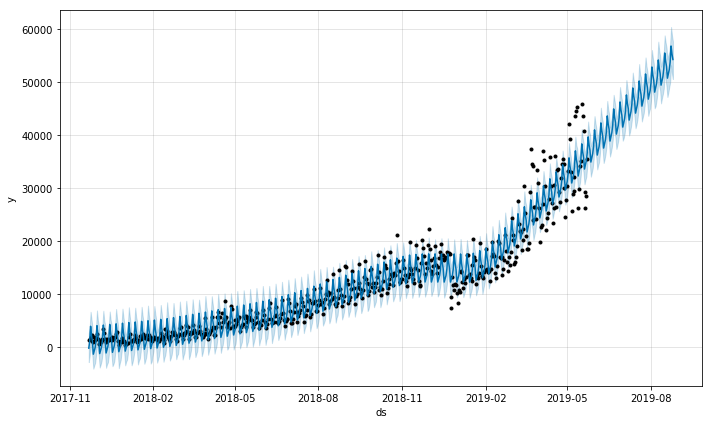

In [72]:
fig1 = m.plot(forecast)

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

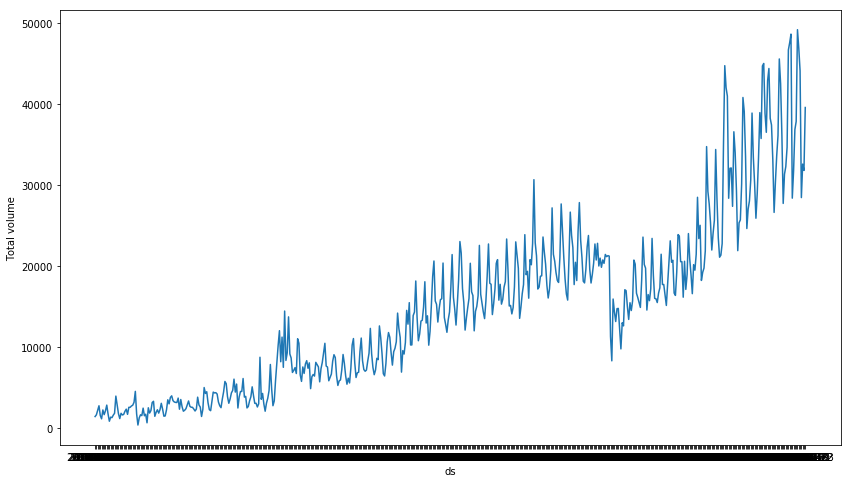

In [55]:
plt.figure(figsize=(14,8))
sns.lineplot(data=financials_df.head(548),x='ds',y='Total volume')

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

Take in dataset, apply log transformation and forecast on that. Coax the data to make it more stationary like. Apply log transformation, predict the log, and then the transform the prediciton.



Another transformation is differencing. Take value of the difference between the 1st and 2nd points, then the 2nd and 3rd, and so on...


Explore whether the variants of the dataset are heteroskedastic -- i.e. is there a trend where variance , not just the y value, is growing or not.

Many models assume constant variance, so we need to adjust for multiplicate seasonal changes (i.e. multipled by a scalar value as opposed to just adding a constant bias factor) if the seasonal variance itself is growing. 

#### Augmented Dickey-Fuller test: what is the stationariy is the data set?

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import adfuller

In [61]:
adfuller(x=financials_df['Gross revenue'].values)

(-3.5444890474980215,
 0.006915387132333552,
 25,
 1748,
 {'1%': -3.4340965268715795,
  '5%': -2.863194882895319,
  '10%': -2.5676510108577832},
 24669.36685071219)

###### Holy shit! Our dataset is actually highly stationary

### Can we use one time series to predict the values of another?

##### Let's try using multivariate autoregressive models

https://en.wikipedia.org/wiki/Vector_autoregression

#### How do we test for one values predictive power over another?

https://en.wikipedia.org/wiki/Granger_causality
    
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html
    
Here, the first column is the dependent variable you want to predict and the second column is the variable you think can help predict the first variable. 

If p-value less than 0.05 (so significant), then the feature you are looking at DOES help to predict the variable

#### How many steps in advance is the 'cause' time-series most predictive of the 'effect' time-series?

How do we select for the ideal time-step? And by extension, optimize/select for the best model? The AIC test.

https://en.wikipedia.org/wiki/Akaike_information_criterion

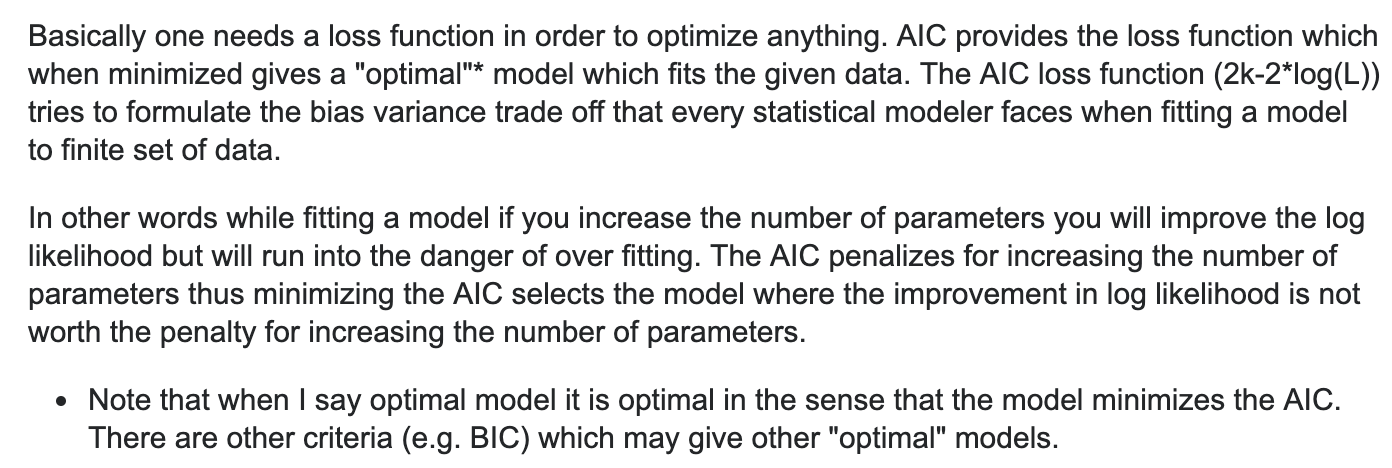

In [65]:
from IPython.display import Image
Image("AIC intuition.png")